In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Load the data
df = pd.read_csv('combined.csv')

# Strip any whitespace from column names
df.columns = df.columns.str.strip()

# Columns to remove, including IP addresses and ports which might not generalize well
columns_to_drop = ["flow ID", "source IP", "destination IP", "source port", "destination port", "date"]
df = df.drop(columns=columns_to_drop)

# Encoding categorical variables, including the 'Label' column
label_encoders = {}
categorical_columns = ['protocol', 'firstPacketDIR', 'mostCommonREQ_FUNC_CODE', 'mostCommonRESP_FUNC_CODE', 'Label']  # Include 'Label' as categorical
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Store the encoded labels separately and drop from dataframe
y = df['Label']
X = df.drop('Label', axis=1)

# Feature scaling
scaler = StandardScaler()
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()  # Only scale numerical columns
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Handling imbalanced dataset with SMOTE
smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)



In [2]:
# SGD Classifier setup with hyperparameter tuning using RandomizedSearchCV
model_params = {
    "SGD Classifier": {
        "model": SGDClassifier(),
        "params": {
            "loss": ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
            "penalty": ['l2', 'l1', 'elasticnet'],
            "alpha": [0.0001, 0.001, 0.01, 0.1],
            "max_iter": [1000, 1500, 2000],
            "learning_rate": ['constant', 'optimal', 'invscaling', 'adaptive'],
            "eta0": [0.01, 0.1, 1]  # Only used when learning_rate is 'constant' or 'adaptive'
        }
    }
}



In [3]:

# Training and evaluation with RandomizedSearchCV
for model_name, mp in model_params.items():
    clf = RandomizedSearchCV(mp['model'], mp['params'], n_iter=10, cv=5, scoring='accuracy', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Best parameters for {model_name}: {clf.best_params_}")
    print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}")

c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_pa

Best parameters for SGD Classifier: {'penalty': 'elasticnet', 'max_iter': 1500, 'loss': 'modified_huber', 'learning_rate': 'adaptive', 'eta0': 0.01, 'alpha': 0.01}
Classification report for SGD Classifier:
              precision    recall  f1-score   support

           0       0.50      0.43      0.46     32590
           1       0.91      0.94      0.93     32681
           2       0.81      0.37      0.51     32310
           3       0.60      0.91      0.72     32706
           4       0.50      0.61      0.55     32617
           5       0.99      0.97      0.98     32661
           6       0.97      0.99      0.98     32516
           7       0.49      0.37      0.42     32701
           8       0.50      0.57      0.53     32514

    accuracy                           0.69    293296
   macro avg       0.70      0.69      0.68    293296
weighted avg       0.70      0.69      0.68    293296



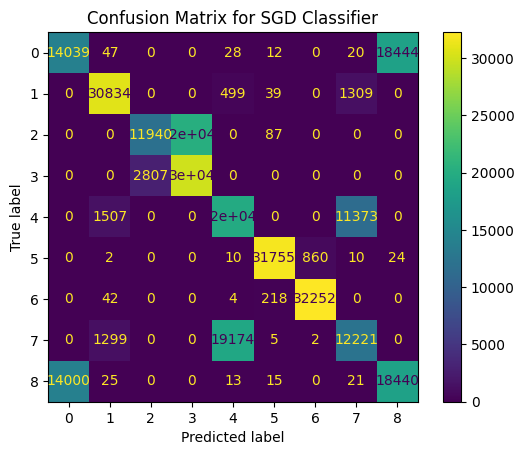

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_conf_matrix(model, X_test, y_test, model_name):
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Example usage:
plot_conf_matrix(clf.best_estimator_, X_test, y_test, model_name)


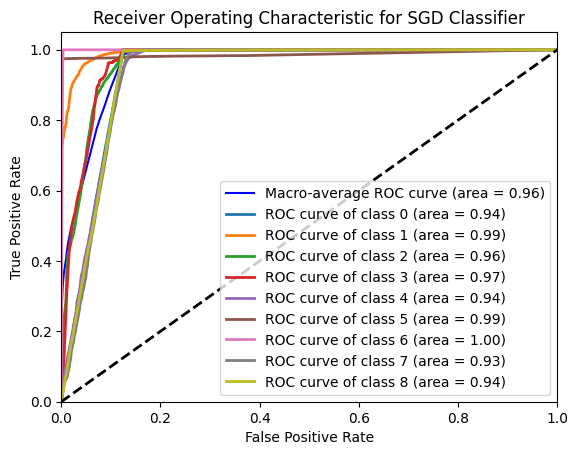

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

def plot_multiclass_roc_curve(model, X_test, y_test, n_classes, model_name):
    # Binarize the labels for multiclass plotting
    y_test_bin = label_binarize(y_test, classes=[*range(n_classes)])
    y_score = model.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Average it and compute AUC
    mean_tpr /= n_classes

    plt.figure()
    plt.plot(all_fpr, mean_tpr, color='blue', label=f'Macro-average ROC curve (area = {auc(all_fpr, mean_tpr):.2f})')

    # Plot ROC curve for each class
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Determine the number of classes in your target labels for correct binarization
num_classes = len(np.unique(y_test))  # Adjust according to how y_test is structured
# Example usage:
plot_multiclass_roc_curve(clf.best_estimator_, X_test, y_test, num_classes, model_name)


